In [1]:
from fastai.conv_learner import *
import xmltodict

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
PATH = Path("../data/hanged_man")

In [5]:
dir_anno = sorted((PATH/"annotations").iterdir())
train_apaths ={i:fn for i,fn in enumerate(dir_anno)}
train_fnid = {fn.name[:-4]:i for i,fn in  enumerate(dir_anno)}
train_t_fnid = {i:fn.name[:-4] for i,fn in  enumerate(dir_anno)}
train_fpaths = {i: (PATH/f"f_train/{fn}.png") for i,fn in train_t_fnid.items()}

In [6]:
classes = {}
t_classes = {}
d_annos = {}
def switch_xy(bb): return np.array([bb[1],bb[0],bb[3],bb[2]])

def crawl_anno(file):
    with open(file,"r") as f:
        data = xmltodict.parse(f.read(), force_list={'object'})
        annos=[]
        for ob in data['annotation']['object']:
            if type(ob)==collections.OrderedDict:
                if ob['name'] not in classes.values():
                    classes.update({len(classes): ob['name']})
                    t_classes.update({ob['name']:len(t_classes)})
                bb = np.array([int(ob['bndbox'][x]) for x in ob['bndbox']])
                bb = switch_xy(bb)
                annos.append([bb,t_classes[ob['name']]])
            else:
                print(data['annotation']['filename'])
                continue
        if len(annos):
            d_annos.update({train_fnid[data['annotation']['filename'][:-4]]:annos})

for p in train_apaths.values():
    crawl_anno(p)

In [7]:
len(classes)

4

In [6]:
d_annos.update*

{0: [[array([182, 404, 261, 530]), 0], [array([248, 455, 305, 504]), 1]],
 2: [[array([264, 398, 375, 479]), 0], [array([ 32, 632,  89, 677]), 1]],
 3: [[array([182, 375, 296, 467]), 0], [array([148, 623, 201, 676]), 1]],
 4: [[array([144, 431, 244, 560]), 0], [array([325, 497, 388, 536]), 1]],
 6: [[array([163, 458, 266, 575]), 0], [array([349, 536, 396, 584]), 1]],
 7: [[array([170, 415, 333, 478]), 0], [array([ 33, 580,  95, 611]), 1]],
 8: [[array([159, 477, 269, 550]), 0], [array([377, 360, 417, 392]), 1]],
 10: [[array([219, 453, 331, 536]), 0], [array([125, 408, 184, 447]), 1]],
 11: [[array([196, 431, 292, 518]), 0], [array([293, 426, 340, 468]), 1]],
 12: [[array([165, 372, 254, 477]), 0], [array([260, 679, 317, 723]), 1]],
 13: [[array([179, 397, 281, 495]), 0], [array([155, 598, 213, 635]), 1]],
 14: [[array([199, 372, 292, 455]), 0],
  [array([126, 602, 201, 638]), 2],
  [array([157, 560, 229, 599]), 2],
  [array([ 90, 656, 158, 698]), 2]],
 15: [[array([168, 406, 268, 519]

In [8]:
import random
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    b = np.array([int(i) for i in b])
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], classes[c], sz=16)
        
def draw_idx(i):
    im_a = d_annos[i]
    im = open_image(train_fpaths[i])
    print(im.shape)
    draw_im(im, im_a)

(540, 960, 3)


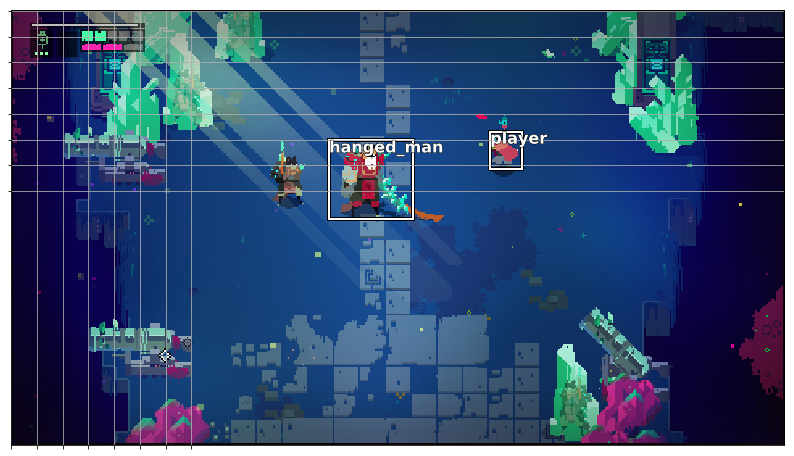

In [12]:
idx = random.choice(list(d_annos.keys()))
# idx = 16
draw_idx(idx)

In [13]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [14]:
trn_lrg_anno = {a: get_lrg(b) for a,b in d_annos.items()}

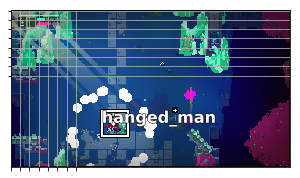

In [15]:
idx = random.choice(list(d_annos.keys()))
b,c = trn_lrg_anno[idx]
b = bb_hw(b)
ax = show_img(open_image(train_fpaths[idx]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], classes[c], sz=16)

In [16]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'
JPEGS = "f_train"

In [17]:
df = pd.DataFrame({"fn":[f'{train_t_fnid[id]}.png' for id in trn_lrg_anno.keys()],
                   'cat':[classes[trn_lrg_anno[id][1]] for id in trn_lrg_anno.keys()]}, columns=["fn","cat"])
df.to_csv(CSV,index=False)

In [18]:
f_model = resnet34
sz=224
bs=8

In [19]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [20]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [21]:
lrf=learn.lr_find(1e-5,100)

 70%|███████   | 90/128 [00:05<00:02, 16.86it/s, loss=2.19] 


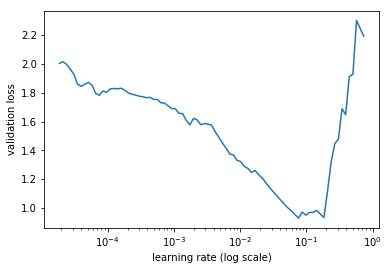

In [22]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [23]:
lr = 2e-1

In [33]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss   accuracy                   
    0      20.085758  677648.598808 0.610236  
    1      14.121252  141123322.412385 0.653543             
    2      12.508989  137075231.698043 0.799213             
    3      5.618357   5901734.19066 0.870079                
    4      3.32445    154760.971681 0.944882                



[array([154760.97168]), 0.9448818897637795]

In [34]:
lrs = np.array([lr/1000,lr/100,lr])

In [35]:
learn.freeze_to(-2)

 70%|███████   | 90/128 [00:08<00:03, 10.96it/s, loss=5.95]


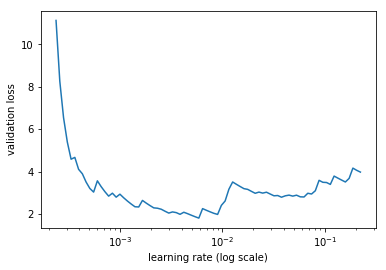

In [38]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(2)

In [39]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      3.104865   63138.642869 0.925197  



[array([63138.64287]), 0.9251968503937008]

In [40]:
learn.unfreeze()

In [41]:
learn.save('clas_one2')

In [42]:
learn.load('clas_one2')

In [43]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

In [44]:
y[0]

1

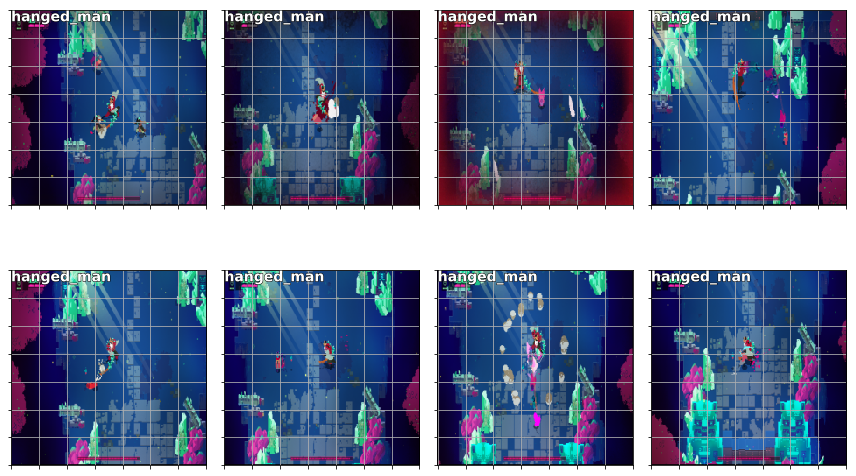

In [45]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [46]:
x,y=next(iter(md.val_dl))
ima=md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0]))
b
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

AttributeError: 'int' object has no attribute 'cpu'

In [47]:
BB_CSV = PATH/'tmp/bb.csv'

In [48]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_lrg_anno.keys()])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [f"{train_t_fnid[o]}.png" for o in trn_lrg_anno.keys()], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [49]:
f_model=resnet34
sz=224
bs=8
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [50]:
x,y=next(iter(md.val_dl))

In [51]:
y[idx]

IndexError: index 792 is out of range for dimension 0 (of size 64)

[105.  92.  10.  15.]
[105.  92.  10.  15.]


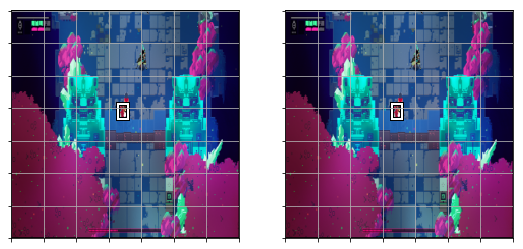

In [52]:
idx = random.choice(range(64))
fig,axes = plt.subplots(1,2, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [53]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

 88%|████████▊ | 14/16 [00:04<00:00,  3.12it/s, loss=508]


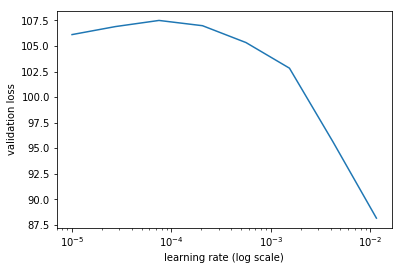

In [56]:
learn.lr_find(1e-5,100)
learn.sched.plot(0)

In [57]:
lr = 3e-2

In [59]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                           
    0      241.508989 57.444439 
    1      367.853938 273.305873                         
    2      252.454611 58.265023                          



[array([58.26502])]

In [60]:
lrs = np.array([lr/100,lr/10,lr])

In [61]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.CENTER, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

[69. 57. 50. 41.]
[69. 57. 50. 41.]
[104.  57.  50.  41.]
[69. 57. 50. 41.]
[104.  57.  50.  41.]
[69. 57. 50. 41.]
[104.  57.  50.  41.]
[69. 57. 50. 41.]
[104.  57.  50.  41.]


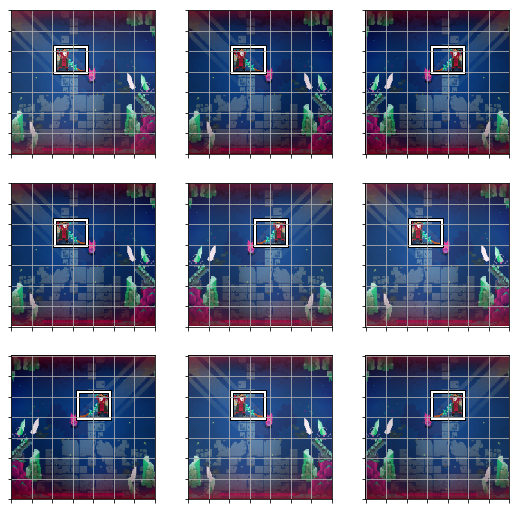

In [62]:
idx=2
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [63]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                            
    0      172.352539 7.366102970701597e+20



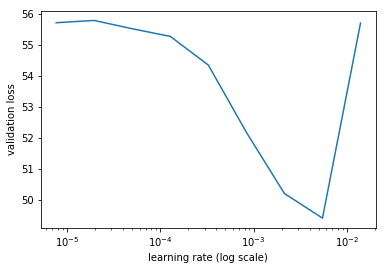

In [64]:
lrf=learn.lr_find(lrs/10000)
learn.sched.plot(1)

In [65]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                           
    0      111.128239 1544.30143
    1      74.198625  203.130966                          
    2      51.910095  21.518312                           



[array([21.51831])]

In [66]:
learn.freeze_to(-3)

In [68]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                           
    0      104.815469 695080.002461
    1      56.817255  77.51932                            



[array([77.51932])]

In [69]:
learn.save('reg42')

In [70]:
learn.load('reg42')

In [71]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))


In [72]:
md.val_y[0]
# preds[0]

array([219., 453., 331., 536.], dtype=float32)

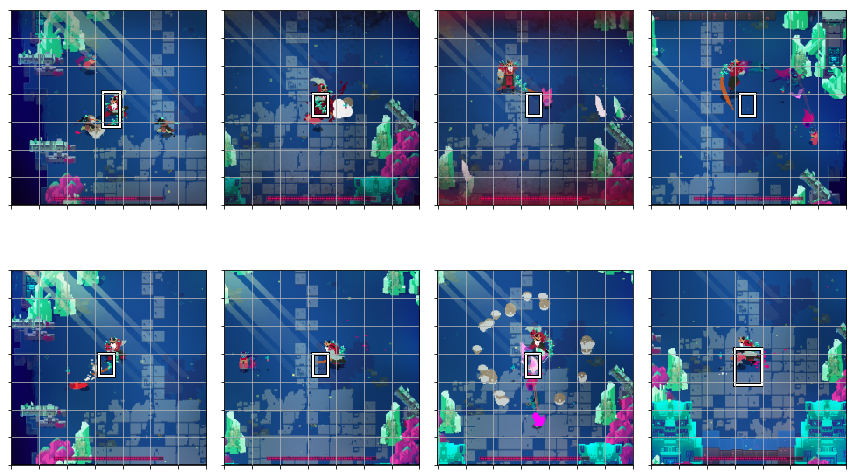

In [73]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
#     ima=md.val_ds.ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
#     b = sbb_hw(md.val_y[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

In [74]:
f_model=resnet34
sz=224
bs=8

val_idxs = get_cv_idxs(len(trn_lrg_anno))

In [75]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [76]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [77]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [78]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [79]:
val_ds2[0][1]

(array([ 91., 106., 136., 124.], dtype=float32), 1)

In [80]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [87]:
x,y=next(iter(md.val_dl))
idx = random.choice(range(len(x)))
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([94., 58., 17., 56.])

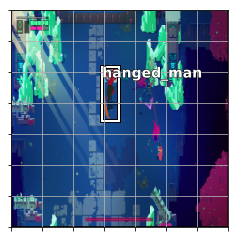

In [88]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [89]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(classes)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [70]:
??ConvnetBuilder

In [95]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

 87%|████████▋ | 111/128 [00:05<00:00, 20.38it/s, loss=127] 


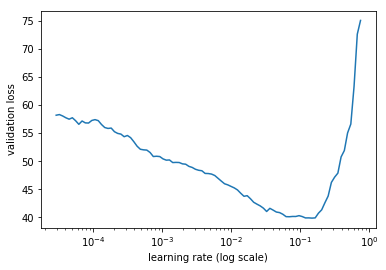

In [91]:
learn.lr_find()
learn.sched.plot()

In [92]:
lr=1e-2

In [96]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

AttributeError: 'list' object has no attribute 'data'

In [74]:
learn.save('reg1_0')

In [75]:
learn.freeze_to(-2)

In [76]:
lrs = np.array([lr/100, lr/10, lr])

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      47.29066   1358351738042.9912 0.0        119.808696



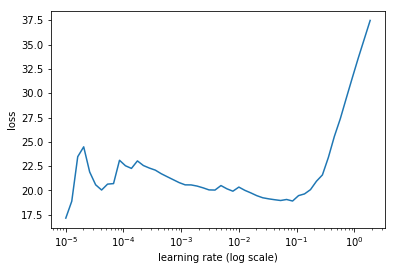

In [77]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [78]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      15.612676  13.710139  0.965217   10.557517 
    1      13.186886  13.153835  0.930435   9.175107      
    2      11.657326  23.234452  0.930435   10.006196     
    3      10.359242  12.23391   0.956522   8.551298      
    4      10.035222  16.349551  0.947826   8.618139      



[array([16.34955]), 0.9478260869565217, 8.618139001597529]

In [79]:
learn.save('reg1_1')

In [80]:
learn.load('reg1_1')

In [81]:
learn.unfreeze()

In [82]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      10.768401  14.187179  0.930435   8.61979   
    1      10.067177  12.699738  0.965217   8.884587      
    2      10.240716  12.325277  0.965217   8.507458      
    3      9.989659   26.336041  0.93913    8.502026      
    4      10.228417  11.862511  0.965217   7.09243       
    5      9.926233   9.51787    0.973913   6.985624      
    6      10.066377  11.12941   0.965217   7.369007      
    7      9.744453   11.021908  0.965217   7.882941      
    8      9.086416   9.729406   0.965217   7.028376      
    9      8.772699   9.486838   0.965217   6.697227      



[array([9.48684]), 0.9652173913043478, 6.697226934847625]

In [83]:
learn.save('reg1')

In [23]:
learn.load('reg1')

KeyError: 'unexpected key "8.3.weight" in state_dict'

In [24]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [86]:
from scipy.special import expit

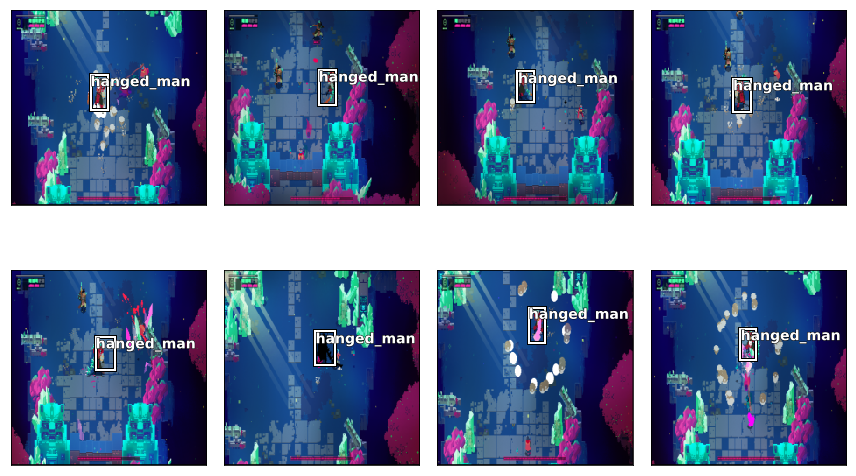

In [89]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

In [ ]:
learner.